In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train, validation = tf.keras.utils.image_dataset_from_directory(
    directory = "/home/wartin/Dataset_4_clases" ,
    labels='inferred',
    label_mode= "int",
    class_names=None,
    color_mode='rgb',
    batch_size= BATCH_SIZE,
    image_size= IMG_SIZE,
    shuffle=True,
    seed=126,
    validation_split=0.2,
    subset="both",
    interpolation='bilinear',
    crop_to_aspect_ratio=False,
)

class_names = train.class_names
print(class_names)


2024-04-28 21:25:01.591976: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 21:25:01.592000: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 21:25:01.592768: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-28 21:25:01.598304: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-28 21:25:02.120030: W tensorflow/compiler/tf2

Found 4000 files belonging to 4 classes.
Using 3200 files for training.
Using 800 files for validation.


2024-04-28 21:25:04.216090: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-28 21:25:04.216370: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-28 21:25:04.247394: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

['herida_y_picadura', 'podrida', 'quemadura_y_otros', 'sanas_1000']


In [3]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

val_batches = tf.data.experimental.cardinality(validation)
test_dataset = validation.take(val_batches // 5)
validation_dataset = validation.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

print("Forma de los datos de entrenamiento:", image_batch.shape)
print("Forma de las etiquetas de entrenamiento:", labels_batch.shape)

(32, 224, 224, 3)
(32,)
Number of validation batches: 20
Number of test batches: 5
Forma de los datos de entrenamiento: (32, 224, 224, 3)
Forma de las etiquetas de entrenamiento: (32,)


In [4]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(224, 224, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [5]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet101(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
base_model.trainable = False


print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  345


In [6]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2024-04-28 21:25:08.175527: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-04-28 21:25:08.599643: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-04-28 21:25:08.646338: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


(32, 7, 7, 2048)


In [7]:
base_model.trainable = False

In [8]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

act = "relu"
x = tf.keras.layers.Dense(units=512, activation=act)(x)
x = tf.keras.layers.Dense(units=512, activation=act)(x)
x = tf.keras.layers.Dense(units=128, activation=act)(x)

x = tf.keras.layers.Dropout(0.5)(x)  # Regularización con dropout
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()
len(model.trainable_variables)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d (  (None, 2048)              0     

8

In [9]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

base_learning_rate = 0.000270088126636346
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

initial_epochs = 5

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[callback])

20/20 [==============================] - 2s 43ms/step - loss: 1.4672 - sparse_categorical_accuracy: 0.2484
initial loss: 1.47
initial accuracy: 0.25
Epoch 1/5


2024-04-28 21:25:16.698215: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f2ba5846fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-28 21:25:16.698235: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-04-28 21:25:16.698238: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-04-28 21:25:16.701713: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1714353916.768860 3571807 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 [==============================] - 11s 63ms/step - loss: 0.6957 - sparse_categorical_accuracy: 0.7337 - val_loss: 0.4331 - val_sparse_categorical_accuracy: 0.8375
Epoch 2/5
100/100 [==============================] - 7s 73ms/step - loss: 0.4237 - sparse_categorical_accuracy: 0.8447 - val_loss: 0.3535 - val_sparse_categorical_accuracy: 0.8875
Epoch 3/5
100/100 [==============================] - 7s 73ms/step - loss: 0.3209 - sparse_categorical_accuracy: 0.8884 - val_loss: 0.4057 - val_sparse_categorical_accuracy: 0.8578
Epoch 4/5
100/100 [==============================] - 7s 73ms/step - loss: 0.2677 - sparse_categorical_accuracy: 0.9069 - val_loss: 0.3221 - val_sparse_categorical_accuracy: 0.8875
Epoch 5/5
100/100 [==============================] - 7s 73ms/step - loss: 0.2471 - sparse_categorical_accuracy: 0.9094 - val_loss: 0.3619 - val_sparse_categorical_accuracy: 0.8781


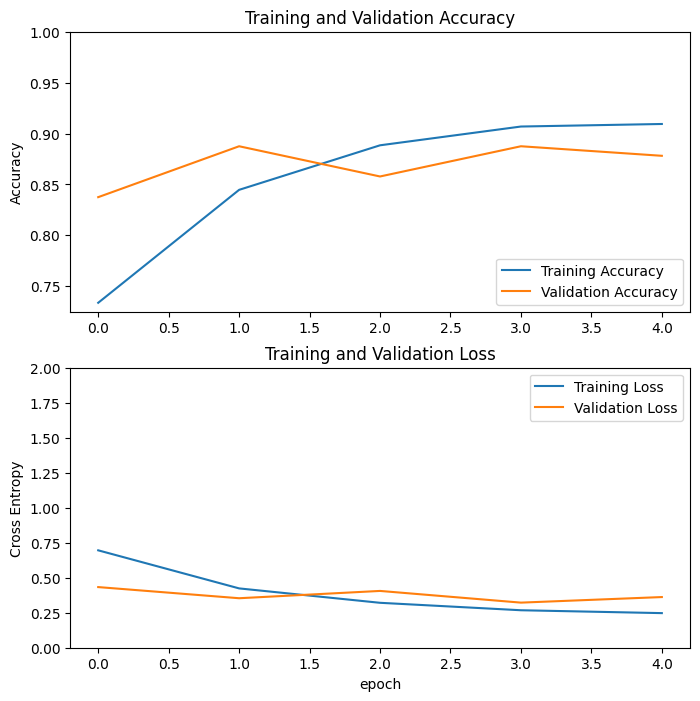

In [10]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [11]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  345


In [12]:
# Fine-tune from this layer onwards
fine_tune_at = 245

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d (  (None, 2048)              0     

In [13]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=[callback])

Epoch 5/15
100/100 [==============================] - 24s 103ms/step - loss: 0.2253 - sparse_categorical_accuracy: 0.9247 - val_loss: 0.3331 - val_sparse_categorical_accuracy: 0.9016
Epoch 6/15
100/100 [==============================] - 9s 94ms/step - loss: 0.1433 - sparse_categorical_accuracy: 0.9519 - val_loss: 0.3007 - val_sparse_categorical_accuracy: 0.9047
Epoch 7/15
100/100 [==============================] - 9s 94ms/step - loss: 0.1065 - sparse_categorical_accuracy: 0.9644 - val_loss: 0.2786 - val_sparse_categorical_accuracy: 0.9297
Epoch 8/15
100/100 [==============================] - 10s 95ms/step - loss: 0.0860 - sparse_categorical_accuracy: 0.9706 - val_loss: 0.3269 - val_sparse_categorical_accuracy: 0.9078
Epoch 9/15
100/100 [==============================] - 10s 96ms/step - loss: 0.0842 - sparse_categorical_accuracy: 0.9719 - val_loss: 0.2708 - val_sparse_categorical_accuracy: 0.9297
Epoch 10/15
100/100 [==============================] - 10s 96ms/step - loss: 0.0548 - spars

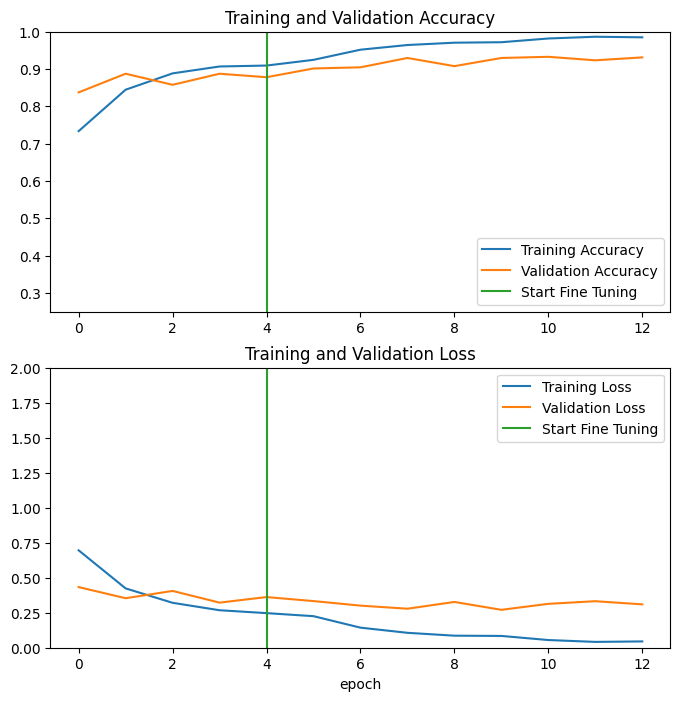

In [14]:
acc += history_fine.history['sparse_categorical_accuracy']
val_acc += history_fine.history['val_sparse_categorical_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.25, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [15]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score
y_t = model.predict(test_dataset)
y_t = np.argmax(y_t,-1)
# Inicializar una lista para almacenar las etiquetas
y_p = []

# Iterar sobre el conjunto de datos de prueba para extraer las etiquetas
for _, label in test_dataset:
    y_p.append(label.numpy())  # Convertir el tensor de etiqueta a un arreglo NumPy y agregarlo a la lista

# Convertir la lista de etiquetas a un arreglo NumPy para poder usarlo en las métricas de evaluación
y_p = np.concatenate(y_p)

# Luego, puedes calcular las métricas de evaluación usando y_t (las predicciones del modelo) y y_p (las etiquetas verdaderas)
print(accuracy_score(y_t, y_p))
print(precision_score(y_t, y_p, average='macro'))
print(recall_score(y_t, y_p, average='macro'))
print(f1_score(y_t, y_p, average='macro'))


print(history.history.keys())

5/5 [==============================] - 1s 46ms/step
0.95
0.9457918050941306
0.9579545454545454
0.9498611815983521
dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


In [16]:
import itertools
def plot_confusion_matrix(cm,classes,normalize=False,title="Confusion_matrix",cmap=plt.cm.Blues):
  plt.imshow(cm,interpolation="nearest",cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks=np.arange(len(classes))
  plt.xticks(tick_marks,classes,rotation=45)
  plt.yticks(tick_marks,classes)

  if normalize:
    cm=cm.astype("float") / cm.sum(axis=1)[:,np.newaxis]
    cm = cm.round(decimals=4)
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix,without normalization")                                       # se define la matriz de confusion.
  print(cm)

  thresh = cm.max() /2.
  for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,cm[i,j],
                    horizontalalignment="center",
                    color="white" if cm[i,j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.savefig("matrix.png")

Confusion matrix,without normalization
[[27  0  0  0]
 [ 1 41  2  0]
 [ 0  0 39  0]
 [ 2  1  2 45]]


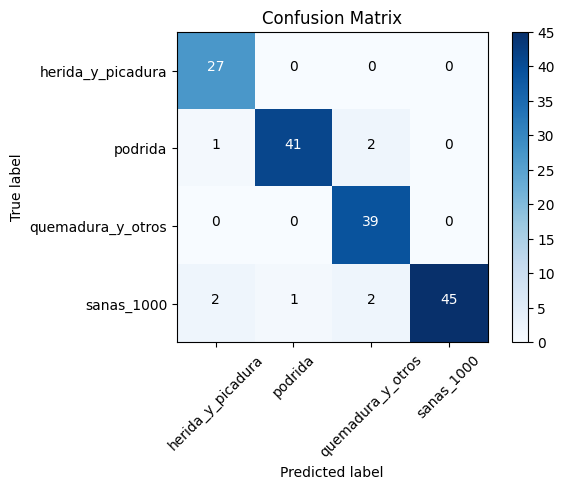

In [17]:
cm_plot_labels = ['herida_y_picadura', 'podrida', 'quemadura_y_otros', 'sanas_1000']
cm = confusion_matrix(y_true=y_t,y_pred=y_p)                                             # se muestra dicha matriz de confusion
plot_confusion_matrix(cm=cm, classes=cm_plot_labels,title="Confusion Matrix")

Normalized confusion matrix
[[1.     0.     0.     0.    ]
 [0.0227 0.9318 0.0455 0.    ]
 [0.     0.     1.     0.    ]
 [0.04   0.02   0.04   0.9   ]]


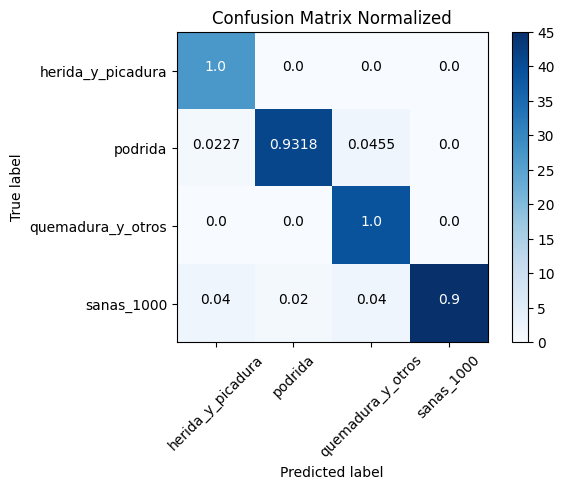

In [18]:
cm_plot_labels = ['herida_y_picadura', 'podrida', 'quemadura_y_otros', 'sanas_1000']
cm = confusion_matrix(y_true=y_t,y_pred=y_p)                                             # se muestra dicha matriz de confusion normalizada
plot_confusion_matrix(cm=cm, classes=cm_plot_labels,normalize = True ,title="Confusion Matrix Normalized")

In [20]:
model.save('ResNet101_opti_with_fine_tuning.h5')

TypeError: Cannot serialize object Ellipsis of type <class 'ellipsis'>. To be serializable, a class must implement the `get_config()` method.